<a href="https://colab.research.google.com/github/basselkassem/probabilistic-ml/blob/main/naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


tfd = tfp.distributions
tfb = tfp.bijectors
print(tf.__version__)
print(tfp.__version__)

2.4.1
0.12.1


# Load Data

In [2]:
data, info = tfds.load('iris', as_supervised = True, with_info = True, data_dir = 'data',)
data_iter = data['train'].as_numpy_iterator()
X_data, y_data = [], []
for X, y in data_iter:
  X_data.append(X)
  y_data.append(y)

X_train, X_test, y_train, y_test = train_test_split(
    np.array(X_data), np.array(y_data), shuffle = True, stratify = y_data,
    train_size = 0.8,
)

labels_num = len(np.unique(y_train))
features_num = X_train.shape[-1]

Shuffling and writing examples to data/iris/2.0.0.incompleteIUX1MF/iris-train.tfrecord


Dataset iris downloaded and prepared to data/iris/2.0.0. Subsequent calls will reuse this data.


In [3]:
print('train:', X_train.shape, y_train.shape)
print('test:', X_test.shape, y_test.shape)

train: (120, 4) (120,)
test: (30, 4) (30,)


## Explore the data

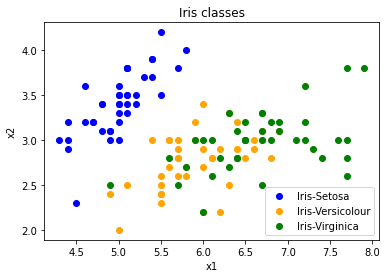

In [4]:
ind2label = {0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}
labels = ['Iris-Setosa', 'Iris-Versicolour','Iris-Virginica']
colors = ['blue', 'orange', 'green']
def plot_data(X, y):
  for i in range(labels_num):
    ids = np.where(y == i)
    plt.scatter(X[ids, 0], X[ids, 1], color = colors[i], label = ind2label[i])
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.title('Iris classes')
  plt.legend()
plot_data(X_train, y_train)

# Fitting Naive-Bayes Model Manually

## Prior

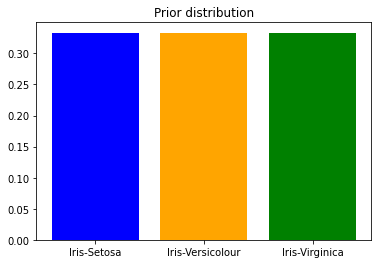

In [19]:
def get_prior(y):
  probs = [len(y[y == lbl]) / len(y) for lbl in range(labels_num)]
  return  tfd.Categorical(probs = probs)

prior = get_prior(y_train)

plt.bar(range(labels_num), prior.prob(np.arange(labels_num)), color = colors)
plt.xticks(np.arange(labels_num), [ind2label[i] for i in np.arange(labels_num)])
plt.title('Prior distribution')
plt.show()

## Likelihood

In [20]:
def P_X_given_y(X, y, features_num = 2):
  mus = np.zeros((labels_num, features_num))
  stds = np.zeros((labels_num, features_num))
  for label in range(labels_num):
    ids = np.where(y == label)
    X_given_y = np.squeeze(X[ids, 0:features_num])
    mus[label] = np.mean(X_given_y, axis = 0,)
    stds[label] = np.std(X_given_y, axis = 0,)
  return tfd.MultivariateNormalDiag(loc = mus, scale_diag= stds )

likelihood = P_X_given_y(X_train, y_train, features_num=features_num)
likelihood

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[4] dtype=float64>

## Maximum the likelihood

<Figure size 720x432 with 0 Axes>

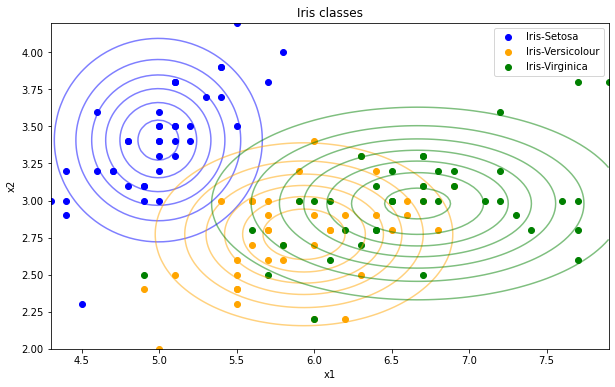

In [21]:
def get_meshgrid(x0_range, x1_range, samples_num):
  x0 = np.linspace(x0_range[0], x0_range[1], samples_num)
  x1 = np.linspace(x1_range[0], x1_range[1], samples_num)
  return np.meshgrid(x0, x1)

def draw_countor(prob_fn, batch_shape, x0_range, x1_range, samples_num = 100, levels = None):
  xx, yy = get_meshgrid(x0_range, x1_range, samples_num)
  Z = np.expand_dims(np.array([xx.ravel(), yy.ravel()]).T, 1)
  Z =  prob_fn(Z)
  Z = np.array(Z).T.reshape(batch_shape, *xx.shape)
  for batch in range(batch_shape):
    if levels is not None:
      plt.contourf(xx, yy, Z[batch], levels = levels, colors=colors, alpha = 0.2)
    else:
      plt.contour(xx, yy, Z[batch], colors=colors[batch], alpha = 0.5,)

plt.figure(figsize=(10, 6))
x0_range = (X_train[:, 0].min(), X_train[:, 0].max())
x1_range = (X_train[:, 1].min(), X_train[:, 1].max())
plt.figure(figsize=(10, 6))
plot_data(X_train, y_train)
likelihood = P_X_given_y(X_train, y_train, features_num=2)
draw_countor(likelihood.prob, 3, x0_range, x1_range,)
plt.show()

## Test the model

In [109]:
def predict(likelihood, prior, x):
  if len(x.shape) > 1:
    x_ = np.expand_dims(x, 1)
  else:
    x_ = np.expand_dims(x, 0)
  prior_prob = tf.cast(prior.probs, tf.float64)
  ll_porb = tf.cast(likelihood.prob(x_), tf.float64)
  return np.argmax(ll_porb * prior_prob, axis = -1)

In [45]:
likelihood = P_X_given_y(X_train, y_train, features_num)
yhat = predict(likelihood, prior, X_test[:, :features_num])
print(f'Accuracy: {accuracy_score(y_test, yhat):.2}')
print(f"F1 Score: {f1_score(y_test, yhat, average = 'weighted'):.2}")

Accuracy: 0.97
F1 Score: 0.97


<Figure size 720x432 with 0 Axes>

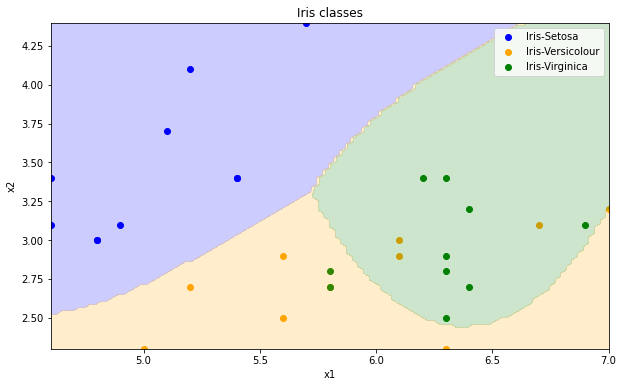

In [31]:
plt.figure(figsize=(10, 6))
x0_range = (X_test[:, 0].min(), X_test[:, 0].max())
x1_range = (X_test[:, 1].min(), X_test[:, 1].max())
plt.figure(figsize=(10, 6))
plot_data(X_test, y_test)
likelihood = P_X_given_y(X_test, y_test, features_num=2)
draw_countor(lambda x : predict(likelihood, prior, x), 1, x0_range, x1_range, levels = [-0.5, 0.5, 1.5, 2.5])
plt.show()

# Learning the Model

In [53]:
prior = get_prior(y_train)
prior

<tfp.distributions.Categorical 'Categorical' batch_shape=[] event_shape=[] dtype=int32>

In [94]:
def nll(dist, X):
  return -tf.reduce_mean(dist.log_prob(X))

@tf.function
def get_grads_and_loss(dist, X):
  with tf.GradientTape() as tape:
    loss = nll(dist, X)
  grads = tape.gradient(loss, dist.trainable_variables)
  return grads, loss

In [143]:
label_X = []
mus = []
stds = []
util_dists = []

for lbl in range(labels_num):
  ids = np.where(y_train == lbl)
  label_X.append(X_train[ids])
  mus.append(tf.Variable(tf.zeros((features_num,))))
  stds.append(tfp.util.TransformedVariable(tf.ones((features_num, )), tfb.Exp()))
  util_dists.append(tfd.Normal(mus[lbl], stds[lbl]))

for lbl in range(labels_num):
  print('----------')
  print('label:', ind2label[lbl])
  print('----------')
  opt = tf.keras.optimizers.Adam(0.01)
  for epoch in range(3000):
    grads, loss = get_grads_and_loss(util_dists[lbl], label_X[lbl])
    opt.apply_gradients(zip(grads, util_dists[lbl].trainable_variables))
    if epoch % 500 == 0:
      print(f'Epoch {epoch}, Loss {loss:.3f}')


temp_dist = tfd.Normal(mus, [std.numpy() for std in stds])
trainable_likelihood = tfd.Independent(temp_dist, reinterpreted_batch_ndims = 1)

----------
label: Iris-Setosa
----------
Epoch 0, Loss 5.798
Epoch 500, Loss 0.740
Epoch 1000, Loss 0.271
Epoch 1500, Loss -0.078
Epoch 2000, Loss -0.094
Epoch 2500, Loss -0.094
----------
label: Iris-Versicolour
----------
Epoch 0, Loss 8.870
Epoch 500, Loss 1.350
Epoch 1000, Loss 0.876
Epoch 1500, Loss 0.589
Epoch 2000, Loss 0.360
Epoch 2500, Loss 0.357
----------
label: Iris-Virginica
----------
Epoch 0, Loss 12.161
Epoch 500, Loss 1.690
Epoch 1000, Loss 1.374
Epoch 1500, Loss 1.005
Epoch 2000, Loss 0.650
Epoch 2500, Loss 0.573


In [144]:
yhat = predict(trainable_likelihood, prior, X_test[:, :features_num])
print(f'Accuracy: {accuracy_score(y_test, yhat):.2}')
print(f"F1 Score: {f1_score(y_test, yhat, average = 'weighted'):.2}")

Accuracy: 0.97
F1 Score: 0.97


In [145]:
trainable_mean = trainable_likelihood.mean().numpy()
trainable_cov = trainable_likelihood.stddev().numpy()

mean = likelihood.mean().numpy()
cov = likelihood.stddev().numpy()

print(f'Mean estimation error: {np.linalg.norm(trainable_mean - mean):.6f}')
print(f'Coveriance estimation error: {np.linalg.norm(trainable_cov - cov):.6f}')


Mean estimation error: 0.000004
Coveriance estimation error: 0.000033
